## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [5]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image

Pretty printing has been turned ON


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

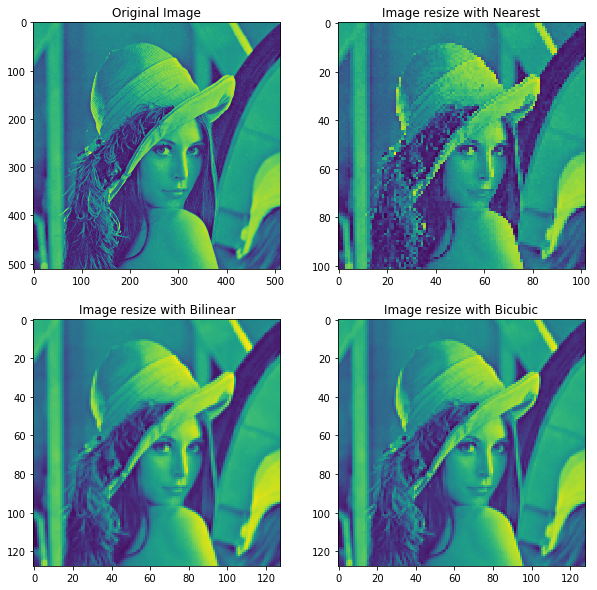

In [6]:
img_path = './images/'
img_name = 'lena-grey.bmp'
lena_im = io.imread(img_path.__add__(img_name))
lena_im_float = img_as_float(lena_im)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0, ax1, ax2, ax3 = axes.ravel()
ax0.imshow(lena_im)
ax0.set_title('Original Image')

new_size = 20
lena_resize = misc.imresize(lena_im_float, new_size, 'nearest')
ax1.imshow(lena_resize)
ax1.set_title('Image resize with Nearest')

new_size = 25
lena_resize = misc.imresize(lena_im_float, new_size, 'bilinear')
ax2.imshow(lena_resize)
ax2.set_title('Image resize with Bilinear')

new_size = 25
lena_resize = misc.imresize(lena_im_float, new_size, 'bicubic')
ax3.imshow(lena_resize)
ax3.set_title('Image resize with Bicubic')

In [7]:
img_path = './images/'
img_name_apple = 'apple.jpeg'
#apple = io.imread(img_path.__add__(img_name))
apple_grey = io.imread(img_path.__add__(img_name_apple), as_grey=True)
#io.imshow(apple_grey)
img_name_orange = 'orange.jpeg'
#orange = io.imread(img_path.__add__(img_name_orange))
orange_grey = io.imread(img_path.__add__(img_name_orange), as_grey=True)
#io.imshow(orange_grey)

**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


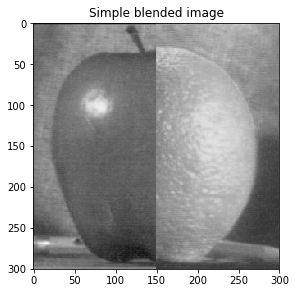

In [15]:
def simple_blend_image (image1, image2):
    
    it1,it2 = image1.shape
    blend_image = np.zeros(image1.shape)
    blend_image[:, :int(it2/2)] = image1[:, :int(it2/2)] #Recorre la imagen desde el inicio hasta la mitad
    blend_image[:, int(it2/2):] = image2[:, int(it2/2):] #Recorre la imagen desde la mitad hasta el final
    
    return blend_image
    
simple_blend = simple_blend_image (apple_grey, orange_grey)
io.imshow(simple_blend)
plt.title ('Simple blended image')

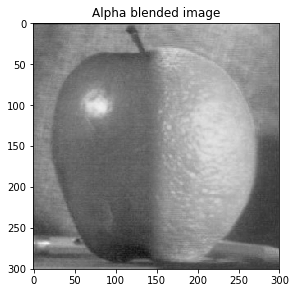

In [14]:
#Alpha blend

def alpha_blend (image1, image2):
    
    it1,it2 = image1.shape
    
    #Create a matrix of zeros
    blend_image = np.zeros(image1.shape)
    
    #Define the window for the alpha blend
    window = 10
    
    # Fill the matrix in the two halfs leaving free a set window 
    blend_image[:, :int(it2/2)- window] = image1[:, :int(it2/2)-window] #Recorre la imagen desde el inicio hasta la mitad
    blend_image[:, int(it2/2)+ window:] = image2[:, int(it2/2)+window:] #Recorre la imagen desde la mitad hasta el final
    
         
    i1 = int(it2/2) - window
    i2 = int(it2/2) + window
    i = np.arange (i1, i2)
    alpha = i/(i1-i2) - i2/(i1-i2)
    
    blend_image[:, i] = (1-alpha)*image2[:, i] + alpha*image1[:, i]
    
    return blend_image

#Apply alpha_blend function
blend_alpha_img = alpha_blend (apple_grey, orange_grey)

#Display image
io.imshow(blend_alpha_img)
plt.title ('Alpha blended image')

In [48]:
#Pyramid blend

def blend_pyramid(image1, image2):
        
    image1 = color.rgb2gray(image1)
    image2 = color.rgb2gray(image2)
    #Mask of the same size of the images to be blended
    blended_image = np.zeros(image1.shape)
    #Comparing if the two images are the same size, if not, resizing
    if image1.shape != image2.shape:
        image2 = transform.resize(image2, image1.shape)
    
    midpoint = int(round(image1.shape[1]/2))
    mask = np.zeros(image1.shape)
    for i in range(mask.shape[0]):
        for j in range(midpoint):
            mask[i,j] = 1
    
    #Create a gaussian pyramid of each image with 3 downscales
    image1_gauss_pyr = list(transform.pyramid_gaussian(image1, downscale=2))
    image2_gauss_pyr = list(transform.pyramid_gaussian(image2, downscale=2))
        
    #Gaussiang pyramid of the mask convertion to list
    mask_gauss_pyr = list(transform.pyramid_gaussian(mask, downscale=2))
    
    image1_laplac_pyr = list()
    image2_laplac_pyr = list()
    
    #Building the laplacian pyramid of each image 
    for i in range(len(image1_gauss_pyr)):
        if i == len(image1_gauss_pyr)-1:
            image1_laplac_pyr.append(image1_gauss_pyr[i])
            image2_laplac_pyr.append(image2_gauss_pyr[i])
        else:
            image1_laplac_pyr.append(image1_gauss_pyr[i] - transform.resize(image1_gauss_pyr[i+1], image1_gauss_pyr[i].shape))
            image2_laplac_pyr.append(image2_gauss_pyr[i] - transform.resize(image2_gauss_pyr[i+1], image2_gauss_pyr[i].shape))
    
    #Blending the images (sum of the convolution of each image with the mask)
    laplacian_blended_pyramid = list()
    for i in range(len(image1_laplac_pyr)):
        laplacian_blended_pyramid.append(image1_laplac_pyr[i]*mask_gauss_pyr[i] + image2_laplac_pyr[i]*(1-mask_gauss_pyr[i]))

    #Collapsing of the final pyramid to get the final image
    for i in range(len(laplacian_blended_pyramid)):
        blended_image += transform.resize(laplacian_blended_pyramid[i], blended_image.shape)
    
    return blended_image  

C:\Users\Lili Valencia\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


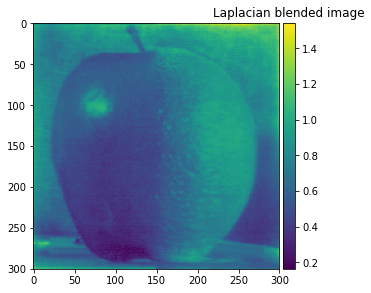

In [50]:
img_path = './images/'
img_name_apple = 'apple.jpeg'
apple_im = io.imread(img_path.__add__(img_name_apple))
apple_im_float = img_as_float(apple_im)

img_name_orange = 'orange.jpeg'
orange_im = io.imread(img_path.__add__(img_name_orange))
orange_im_float = img_as_float(orange_im)

blended_images = blend_pyramid(apple_im_float, orange_im_float)
io.imshow(blended_images)
plt.title ('Laplacian blended image')
